![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

# Analysis of the Earth's Radiation Budget using the CERES product

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/main?labpath=erb-ceres-climatology.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-ceres-climatology.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-ceres-climatology.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-ceres-climatology.ipynb)

## Learning Objectives 🎯

This notebook-tutorial provides an introduction to the use of the Cloud and Earth's Radiant Energy System (CERES) Energy Balanced and Filled (EBAF) Earth's Radiation Budget ([ERB](https://cds.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)) data record for climate studies.

The Earth’s Radiation Budget (ERB) represents the overall balance between incoming and outgoing radiant energy at the Earth’s top-of-the-atmosphere (TOA). This Essential Climate Variable (ECV) is the primary forcing of the climate system and is therefore a fundamental quantity to be monitored to understand the Earth’s climate and its variability. The ERB comprises the quantification of the incoming radiation from the sun and the outgoing reflected shortwave and emitted longwave radiations. The Earth is in a state of dynamic radiative balance; energy arriving from the sun is balanced by outgoing radiation from the top-of-the-atmosphere. Changes in the Earth’s surface and atmosphere (including cloud amount and properties, and concentrations of greenhouse gases) will alter the radiative forcing of the Earth system and change the balance and distribution of outgoing thermal radiation and reflected solar radiation.

In this Jupyter notebook tutorial, we present examples, based on monthly mean ERB products, to illustrate the philosophy on the usage, visualisation, and analysis of the ERB dataset. A first use case provides an analysis of the time averaged global and seasonal climatological distributions of the Earth's radiation budget as well as the monthly mean climatology. The second use case presents the time series and trend analysis of ERB. Step-by-step instructions are provided on data preparation, the use cases are extensively documented and each line of code is explained.

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries


The data have been stored in files written in NetCDF format. To best handle these, we will import the library [Xarray](http://xarray.pydata.org/en/stable/) which is specifically designed for manipulating multidimensional arrays in the field of geosciences. The libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) will also be imported for plotting and visualising the analysed data. We will also import the libraries [zipfile](https://docs.python.org/3/library/zipfile.html) to work with zip-archives, [OS](https://docs.python.org/3/library/os.html) to use OS-functions and pattern expansion, and [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

In [2]:
# Libraries to work with zip-archives, OS functions and pattern expansion
import zipfile
import os

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np
import pandas as pd
# Import a sublibrary method for the seasonal decomposition of the time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Libraries for plotting and visualising the data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)


### Specify data directory

In [ ]:
# Directory to store data
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

# Filename for the zip file downloaded from the CDS
download_zip_file = os.path.join(DATADIR, 'ceres-erb-monthly.zip')
# Filename for the netCDF file which contain the merged contents of the monthly files.
merged_netcdf_file = os.path.join(DATADIR, 'ceres-erb-monthly.nc')

## Explore Data

In the Copernicus Climate Data Store (CDS), a dataset of ERB has been “brokered” from the Clouds and Earth’s Radiant Energy System (CERES) Energy Balanced And Filled (EBAF) edition 4.2. CERES EBAF provides a state-of-the-art Climate Data Record (CDR) of monthly mean top of atmosphere (TOA) radiative fluxes. This widely used CDR is produced by the CERES team at the NASA/Langley center from the CERES instruments onboard the Terra and Aqua satellites. The CERES EBAF data is suitable for analysis of variability at the intra-seasonal, inter-annual, and longer time scales.

You will find further information about the dataset as well as the data in the Climate Data Store catalogue entry Earth’s Radiation Budget, sections "Overview", "Download data" and "Documentation":
- [Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)

### Search for data

To search for data, visit the [CDS website](https://cds-beta.climate.copernicus.eu).
Here you can search for CERES EBAF data using the search bar. The data we need for this use case is the [Earth's radiation budget from 1979 to present derived from satellite observations](https://cds-beta.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview).
This catalogue entry provides data from various sources: NASA CERES EBAF, NOAA/NCEI HIRS OLR, ESA Cloud-CCI, EUMETSAT's CM SAF CLARA-A3, C3S CCI and C3S RMIB TSI.

After selecting the correct catalogue entry, we will specify the product family, the origin, the sensor on satellite (for CCI product family only), the type of variable, the type of climate data record, the time aggregation, the temporal and geographical coverage we are interested in.
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

:::{dropdown} Parameters of data to download

- Product family: `CERES EBAF (Clouds and the Earth's Radiant Energy System (CERES) Energy Balanced And Filled (EBAF))`
- Origin: `NASA (National Aeronautics and Space Administration)`
- Variable: `all` (use `Select all` button)
- Climate data record type: `Thematic Climate Data Record (TCDR)`
- Time aggregation: `Monthly mean`
- Year: `all` (use `Select all` button)
- Month: `all` (use `Select all` button)
- Geographical area: `Whole available region`

:::

At the end of the download form, select "Show API request". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

::: {warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::


### Download the data

With the API request copied into the cells below, running these cells will retrieve and download the data you requested into your local directory.

In [ ]:
dataset = "satellite-earth-radiation-budget"
request = {
    'product_family': 'ceres_ebaf',
    'origin': 'nasa',
    'variable': ['incoming_shortwave_radiation', 
                 'outgoing_longwave_radiation', 
                 'outgoing_shortwave_radiation'
                ],
    'climate_data_record_type': 'thematic_climate_data_record',
    'time_aggregation': 'monthly_mean',
    'year': ['%04d' % (year) for year in range(2000, 2023)],
    'month': ['%02d' % (month) for month in range(0, 13)]
}

client = cdsapi.Client()
client.retrieve(dataset, request, download_zip_file)

2024-12-17 09:17:37,089 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-17 09:17:37,090 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-17 09:17:37,091 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-17 09:17:37,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

c1fb933945b6360c9fe951e3d50def51.zip:   0%|          | 0.00/206M [00:00<?, ?B/s]

'./ceres-erb-monthly.zip'

### Inspect data

The data have been downloaded. We can now unzip the archive and merge all files into one NetCDF file to inspect them. NetCDF is a commonly used format for array-oriented scientifc data. To read and process these data, we will make use of the [Xarray](https://docs.xarray.dev/en/stable/index.html) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient.

We extract all our netCDF files from the zip archive and open them as a single [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [185]:
# Unzip the data. The dataset is splitted in monthly files.
with zipfile.ZipFile(download_zip_file, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)
# Ensure the filelist is in the correct order
filelist = sorted(filelist)

In [186]:
# Open all the files as a single Xarray dataset
ds_ceres = xr.open_mfdataset(filelist)

ds_ceres

<xarray.Dataset> Size: 213MB
Dimensions:         (time: 274, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2000-03-15 ... 2022-12-15
  * lat             (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    solar_mon       (time, lat, lon) float32 71MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    toa_lw_all_mon  (time, lat, lon) float32 71MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    toa_sw_all_mon  (time, lat, lon) float32 71MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    title:                           CERES EBAF (Energy Balanced and Filled) ...
    institution:                     NASA/LaRC (Langley Research Center) Hamp...
    Conventions:                     CF-1.4
    comment:                         Climatology from 07/2005 to 06/2015
    version:                         Edition 4.2; Release Date December 9, 2022
    DOI:                             10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA...
    Fill_Value:                      Fill Value is -999.0
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2023-03-05 19:21:10 GMT Hyrax-1.16.2 htt...

We see that the dataset has three variables **solar_mon**, **toa_lw_all_mon** and **toa_sw_all_mon** which stand for the incoming solar flux, the top of atmosphere (TOA) longwave (LW) and shortwave (SW) fluxes respectively, as well as three dimension coordinates of **lon**, **lat** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **solar_mon**, **toa_lw_all_mon** and **toa_sw_all_mon** data easier, we convert them into three distinct Xarray data arrays. We can also define a new data array **da_toa_erb** that corresponds to the TOA net Earth's radative budget and is defined as the difference between the incoming solar flux and the sum of the outgoing (LW, SW) fluxes at the top the atmosphere.

In [187]:
# Outgoing longwave radiation data array
da_toa_lw = ds_ceres['toa_lw_all_mon']

# Incoming shortwave radiation data array
da_solar = ds_ceres['solar_mon']

# Outgoing shortwave radiation data array
da_toa_sw = ds_ceres['toa_sw_all_mon']

# Creation of the net radiative flux data array
da_toa_erb = da_solar - da_toa_sw - da_toa_lw
# Name of the data array
da_toa_erb = da_toa_erb.rename('toa_erb_all_mon')
# Add some attributes to the new data array
da_toa_erb.attrs = {
    'long_name': "Top of The Atmosphere Net Earth's Radiative Flux",
    'standard_name': "TOA Net Flux",'CF_name': "toa_net_radiative_flux",
    'comment': "none",
    'units': "W.m$^{-2}$",
}

Let us view these data, e.g. the **toa_erb_all_mon** data from our newly created **da_toa_erb** data array:

In [188]:
da_toa_erb

<xarray.DataArray 'toa_erb_all_mon' (time: 274, lat: 180, lon: 360)> Size: 71MB
dask.array<sub, shape=(274, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-03-15 2000-04-15 ... 2022-12-15
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Top of The Atmosphere Net Earth's Radiative Flux
    standard_name:  TOA Net Flux
    CF_name:        toa_net_radiative_flux
    comment:        none
    units:          W.m$^{-2}$

### Plot data

We can visualize one time step to figure out what the data look like. Xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array.

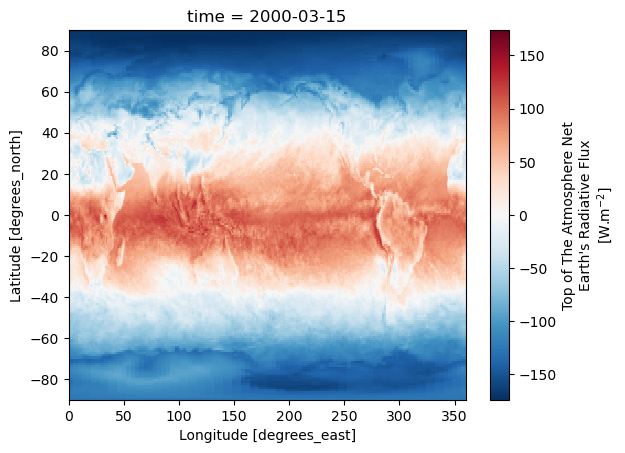

In [189]:
da_toa_erb.isel(time=0).plot()

**Figure 1** shows the Top of the Atmosphere Net Earth's Radiative Flux for March 2000.

An alternative to the built-in Xarray plotting functions is to make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). One of Cartopy’s key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations. In later plots, we will make use of these libraries to produce more customised visualisations.

##  Climatology of the Earth's Radiation Budget

In this section we will study the Earth's radiation budget by analysing separately the averaged global and seasonal climatological distributions of the incoming radiation from the sun, of the outgoing reflected shortwave and emitted longwave radiations, and of the net radiation at the top of the atmosphere.

###  Climatology of the top-of-atmosphere incoming solar radiation

In this section we will analyse the time averaged global and seasonal climatological distributions of the TOA incoming solar radiation (TIS).

#### Time averaged global climatological distribution of TIS

To calculate the mean climatology of the top of the atmosphere incoming solar radiation for the time period January 2001 to December 2021, we have to select the specific time range using the Xarray method `sel()` that indexes the data and dimensions by the appropriate indexers. We can then use the method `mean()` to calculate the mean along the time dimension.

In [190]:
# Select the TOA incoming solar radiation data for the whole time period
solar = da_solar.sel(time=slice('2001-01-01', '2021-12-31'))

# Calculate the mean along the time dimension
solar_mean = solar.mean(dim='time')

We can now visualize the time averaged global climatological distribution of the incoming solar radiation for the period January 2001 - December 2021. This time, we will make use of a combination of the plotting libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a more customised figure.

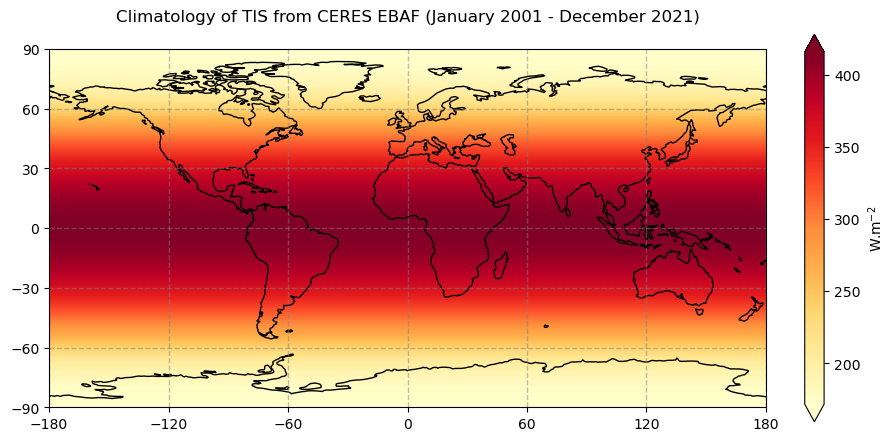

In [191]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig2, ax2 = plt.subplots(
    1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot the data
im = plt.pcolormesh(solar_mean.lon, solar_mean.lat, solar_mean, cmap='YlOrRd')

# Set the figure title, add lat/lon grid and coastlines
ax2.set_title(
    'Climatology of TIS from CERES EBAF (January 2001 - December 2021)',
    pad=20)
# Add coastlines
ax2.coastlines(color='black')
# Define gridlines and ticks
ax2.set_xticks(np.arange(-180, 181, 60))
ax2.set_yticks(np.arange(-90, 91, 30))
# Gridlines
gl = ax2.gridlines(
    linewidth=1, color='gray', alpha=0.5, linestyle='--',
)

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig2.savefig(f'{DATADIR}ceres_solar_climatology.png')

**Figure 2** shows the regular latitude dependent climatological distribution of the incoming solar radiation at the top of the atmosphere, with values decreasing from the tropics to the high latitudes.

#### Time averaged seasonal climatological distribution of TIS

The TOA incoming solar radiation data can also be splitted according to the seasons by using the `groupby()` method, with `'time.season'` as an argument, and then averaged over the years. 
Seasons are defined as follows, using the Northern Hemisphere (NH) as reference:
- NH spring: March, April, May
- NH summer: June, July, August
- NH autumn: September, October, November
- NH winter: December, January, February

In [192]:
# Split data array solar by season
solar_seasonal_climatology = solar.groupby('time.season').mean('time')
solar_seasonal_climatology

<xarray.DataArray 'solar_mon' (season: 4, lat: 180, lon: 360)> Size: 1MB
dask.array<stack, shape=(4, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      Incoming Solar Flux, Monthly Means
    standard_name:  Incoming Solar Flux
    CF_name:        toa_incoming_shortwave_flux
    comment:        none
    units:          W m-2
    valid_min:      0.0
    valid_max:      800.0

The xarray **solar_seasonal_climatology** has four entries in the time dimension (one for each season). The climatology of the incident solar flux distribution can now be plotted for each season.

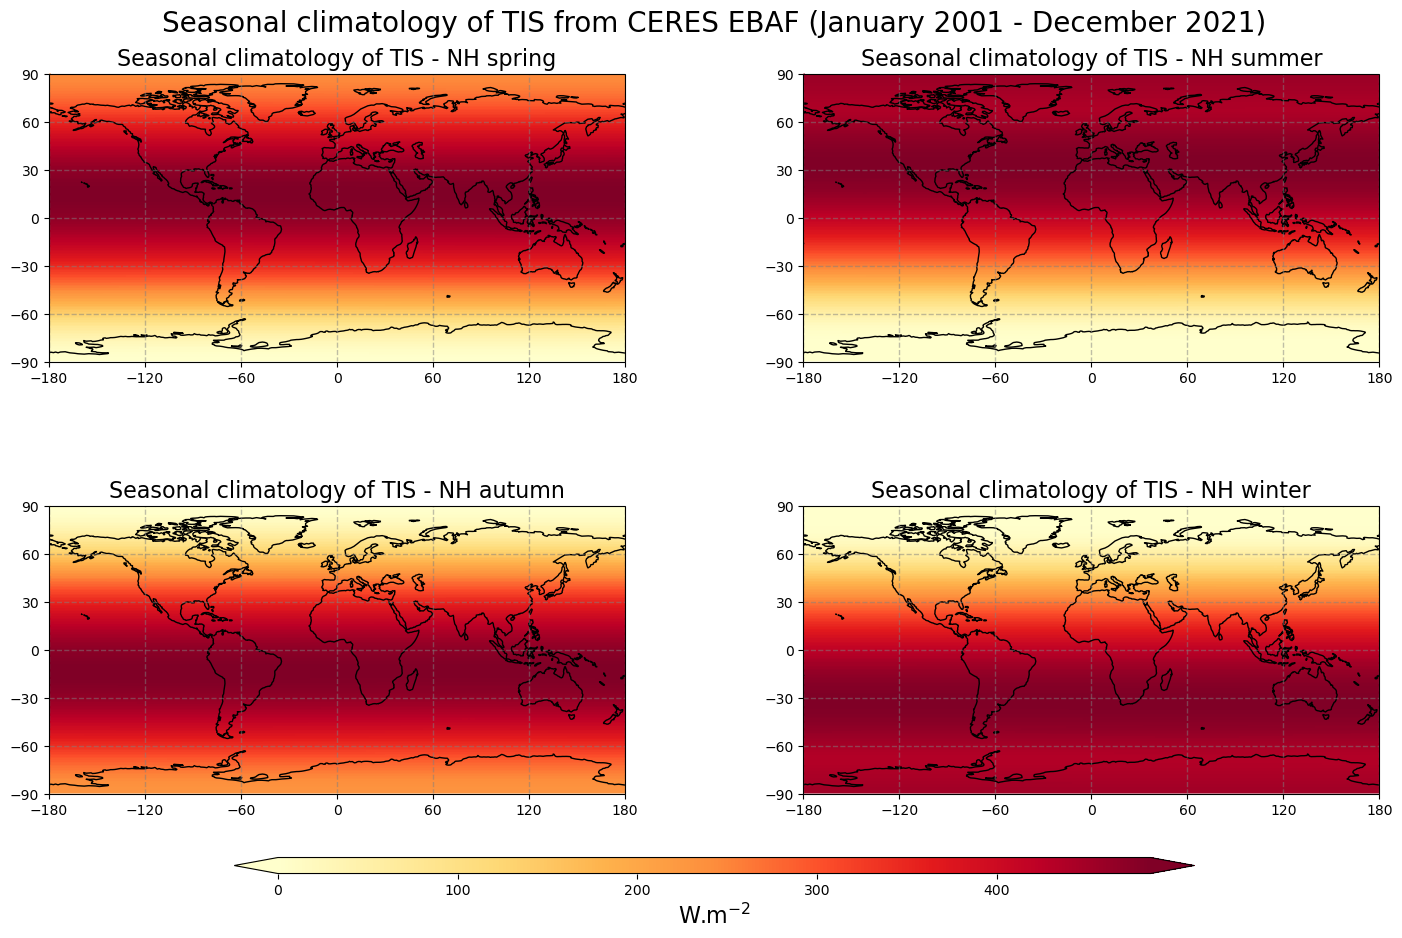

In [193]:
# Create a list of the seasons such as defined in the dataset solar_seasonal_climatology:
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig3, ax3 = plt.subplots(nrows=2,
                         ncols=2,
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'MAM': 'NH spring', 'JJA': 'NH summer', 'SON': 'NH autumn', 'DJF': 'NH winter'}

# Configure the axes and subplot titles
for i_season, c_season in enumerate(seasons):
    # convert i_season index into (row, col) index
    row = i_season // 2
    col = i_season % 2
    # Plot data (coordinates and data) and define colormap
    im = ax3[row][col].pcolormesh(solar_seasonal_climatology.lon,
                                  solar_seasonal_climatology.lat,
                                  solar_seasonal_climatology.sel(season=c_season),
                                  cmap='YlOrRd')
    # Set title and size
    ax3[row][col].set_title('Seasonal climatology of TIS - ' + subtitles[c_season], fontsize=16)
    # Add coastlines
    ax3[row][col].coastlines()
    # Define grid lines and ticks (e.g. from -180 to 180 in an interval of 60)
    ax3[row][col].set_xticks(np.arange(-180, 181, 60))
    ax3[row][col].set_yticks(np.arange(-90, 91, 30))
    # Gridline
    gl = ax3[row][col].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Place the subplots
fig3.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define and place a colorbar at the bottom
cbar_ax = fig3.add_axes([0.2, -0.1, 0.6, 0.02])
cbar = fig3.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('W.m$^{-2}$', fontsize=16)

# Define an overall title
fig3.suptitle('Seasonal climatology of TIS from CERES EBAF (January 2001 - December 2021)',
              fontsize=20)

# Save the figure
fig3.savefig(f'{DATADIR}ceres_solar_seasonal_climatology.png')

**Figure 3** shows the seasonal mean climatology of the top of the atmosphere incoming solar radiation from spring to winter (top left to bottom right panels) derived from CERES EBAF.

<div style="text-align: justify"> The seasonal and latitudinal variability of the incoming solar radiation is remarkable, with the values decreasing progressively from the summer hemisphere to the winter hemisphere and increasing from the winter hemisphere to the summer hemisphere. </div>

#### Zonally averaged monthly mean climatology of TIS

We will now calculate the monthly mean climatology of the top-of-atmosphere incoming solar radiation over the time period January 2001 - December 2021 by first applying the `groupby()` method to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for the top of atmosphere incident solar radiation based on reference January 2001 - December 2021.

In [194]:
solar_clim_month = solar.groupby('time.month').mean("time")
solar_clim_month

<xarray.DataArray 'solar_mon' (month: 12, lat: 180, lon: 360)> Size: 3MB
dask.array<stack, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Incoming Solar Flux, Monthly Means
    standard_name:  Incoming Solar Flux
    CF_name:        toa_incoming_shortwave_flux
    comment:        none
    units:          W m-2
    valid_min:      0.0
    valid_max:      800.0

Let us view the zonal monthly climatology of the TOA incoming solar radiation. To do this, we will average across the longitude bands with the `mean()` method, align the **time** dimension coordinate with the x axis and the **lat** dimension coordinate along the y axis using the method `transpose()`...

In [195]:
solar_zonal_clim_month = solar_clim_month.mean(dim="lon").transpose()
solar_zonal_clim_month

<xarray.DataArray 'solar_mon' (lat: 180, month: 12)> Size: 9kB
dask.array<transpose, shape=(180, 12), dtype=float32, chunksize=(180, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [196]:
# Define contour parameters (min, max and step)
vdiv = 5
vmin = 0
vmax = 500
clevs = np.arange(vmin, vmax, vdiv)

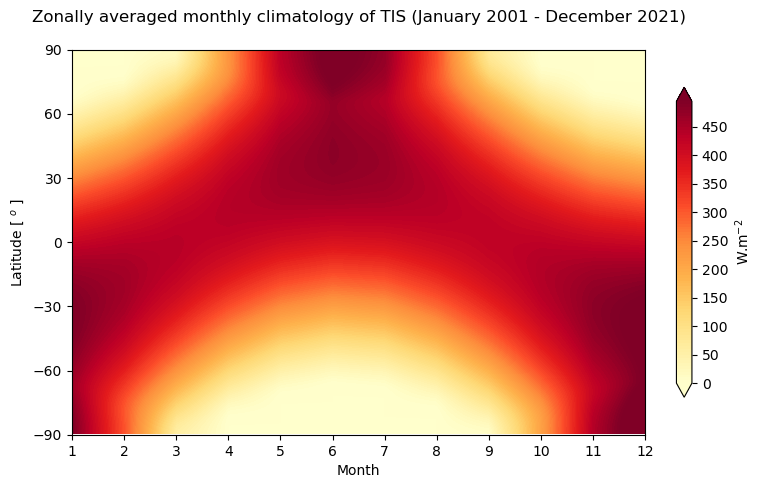

In [197]:
# Define the figure and specify size
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 5))

# Configure the axes and figure title
ax4.set_xlabel('Month')
ax4.set_ylabel('Latitude [ $^o$ ]')
ax4.set_title(
    'Zonally averaged monthly climatology of TIS (January 2001 - December 2021)',
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax4.set_aspect('auto')

# Plot the data as a contour plot
contour = ax4.contourf(
    solar_zonal_clim_month.month,
    solar_zonal_clim_month.lat,
    solar_zonal_clim_month,
    levels=clevs,
    cmap='YlOrRd',
    extend='both'
)
ax4.set_xticks(np.arange(1, 13, 1))
ax4.set_yticks(np.arange(-90, 91, 30))

# Specify the colorbar
cbar = plt.colorbar(contour, fraction=0.025, pad=0.05)
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig4.savefig(f'{DATADIR}ceres_solar_monthly_climatology.png')

**Figure 4** is a Hovmöller diagram that describes the annual variability of the incoming solar radiation at the top of the atmosphere with latitude over the time period January 2001 to December 2021. It is used in meteorology and for climate studies to show how a variable varies with latitude over time.

<div style="text-align: justify"> The main features discussed in the seasonal climatological distribution of the incoming solar flux are present in this plot. Moreover, we observe the influence of the changes in the sun-Earth's distance and geometry (e.g. solar zenith angle) on the (slightly non-symmetric) distribution of the incoming solar radiation. </div>

###  Climatology of the top-of-atmosphere reflected solar flux

In this section we will analyse the time averaged global and seasonal climatological distributions of the top of the atmosphere (TOA) reflected solar flux (RSF).

#### Time averaged global climatological distribution of TOA RSF

To calculate the mean climatology of the top of the atmosphere reflected solar flux for the time period January 2001 to December 2021, we have to select the specific time range using the Xarray method `sel()` that indexes the data and dimensions by the appropriate indexers. We can then use the method `mean()` to calculate the mean along the time dimension. 

In [198]:
# Select the TOA RSF data for the whole time period
toa_sw = da_toa_sw.sel(time=slice('2001-01-01', '2021-12-31'))

# Calculate the mean along the time dimension
toa_sw_mean = toa_sw.mean(dim='time')

We can now make use of a combination of the plotting libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a customised figure and visualise the time averaged global climatological distribution of the TOA reflected solar flux for the period January 2001 - December 2021.

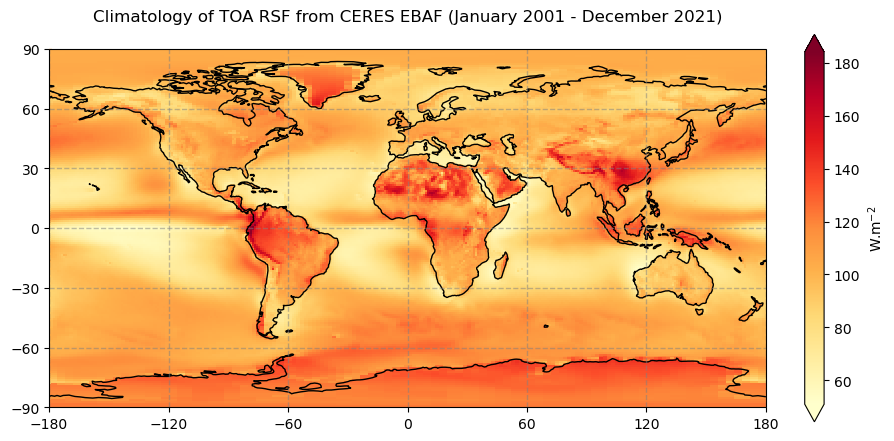

In [199]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(toa_sw_mean.lon, toa_sw_mean.lat, toa_sw_mean, cmap='YlOrRd')

# Set the figure title, add lat/lon grid and coastlines
ax5.set_title(
    'Climatology of TOA RSF from CERES EBAF (January 2001 - December 2021)',
    pad=20)
# Add coastlines
ax5.coastlines(color='black')
# Define gridlines and ticks
ax5.set_xticks(np.arange(-180, 181, 60))
ax5.set_yticks(np.arange(-90, 91, 30))
# Gridlines
gl = ax5.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig5.savefig(f'{DATADIR}ceres_toa_sw_climatology.png')

**Figure 5** shows the global climatology of the top of the atmospohere reflected solar radiation for the time period of January 2001 - December 2021.

<div style="text-align: justify"> The RSF values are the lowest over cloud free ocean areas. The maximum values correspond to high albedo surfaces, such as snow or deserts. Some regions which experience intense convective activity appear as bright areas (central South America, Congo basin and Indonesia). Persistent cloud areas are also clearly visible in this climatology (i.e. the Intertropical Convergence Zone, ITCZ, near the equator, persistent marine stratocumulus clouds around the coast of Namibia and the coast of Peru, for instance). </div>

#### Time averaged seasonal climatological distribution of TOA RSF

We now split the TOA RSF data according to the seasons by using the `groupby()` method, with `'time.season'` as an argument, and then average them over the years.

In [200]:
# Split data array toa_sw by season
toa_sw_seasonal_climatology = toa_sw.groupby('time.season').mean('time')

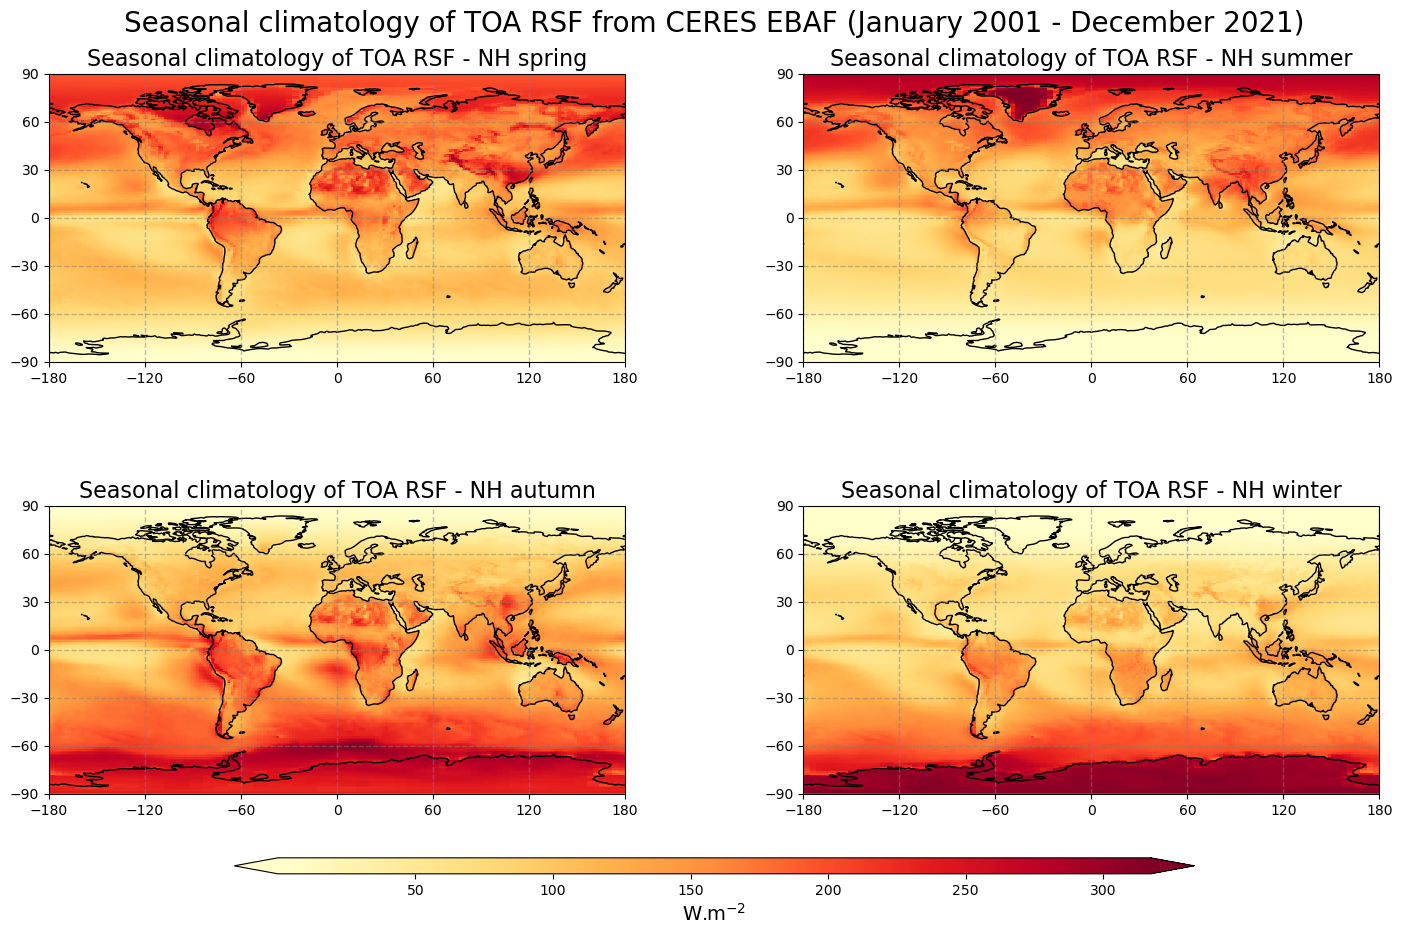

In [201]:
# Create a list of the seasons such as defined in the dataset toa_sw_seasonal_climatology:
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig6, ax6 = plt.subplots(nrows=2,
                         ncols=2,
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'MAM': 'NH spring', 'JJA': 'NH summer', 'SON': 'NH autumn', 'DJF': 'NH winter'}

# Configure the axes and subplot titles
for i_season, c_season in enumerate(seasons):
    # convert i_season index into (row, col) index
    row = i_season // 2
    col = i_season % 2
    # Plot data (coordinates and data) and define colormap
    im = ax6[row][col].pcolormesh(toa_sw_seasonal_climatology.lon,
                                  toa_sw_seasonal_climatology.lat,
                                  toa_sw_seasonal_climatology.sel(season=c_season),
                                  cmap='YlOrRd')
    # Set title and size
    ax6[row][col].set_title('Seasonal climatology of TOA RSF - ' + subtitles[c_season], fontsize=16)
    # Add coastlines
    ax6[row][col].coastlines()
    # Define grid lines and ticks (e.g. from -180 to 180 in an interval of 60)
    ax6[row][col].set_xticks(np.arange(-180, 181, 60))
    ax6[row][col].set_yticks(np.arange(-90, 91, 30))
    # Gridline
    gl = ax6[row][col].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Place the subplots
fig6.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define and place a colorbar at the bottom
cbar_ax = fig6.add_axes([0.2, -0.1, 0.6, 0.02])
cbar = fig6.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('W.m$^{-2}$', fontsize=14)

# Define an overall title
fig6.suptitle('Seasonal climatology of TOA RSF from CERES EBAF (January 2001 - December 2021)',
              fontsize=20)

# Save the figure
fig6.savefig(f'{DATADIR}erb_toa_sw_seasonal_climatology.png')

**Figure 6** shows the seasonal mean climatology of the top of the atmosphere reflected solar flux from spring to winter (top left to bottom right panels) derived from CERES EBAF.

The influence of the albedo surfaces on the outgoing shorwave radiation observed in **Figure 6** is confirmed by the seasonal climatology, with much higher values of TOA RSF over snow and ice in the summer Arctic and Antarctic regions.

#### Zonally averaged montly mean climatology of TOA RSF

We will now calculate the monthly mean climatology of the outgoing shortwave radiation over the time period January 2001 - December 2021 by first applying the `groupby()` method to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for the TOA reflected solar radiation based on reference January 2001 - December 2021.

In [202]:
toa_sw_clim_month = toa_sw.groupby('time.month').mean("time")

Before viewing the zonal monthly climatology of the TOA RSF, we must average across the longitude bands with the `mean()` method, align the **time** dimension coordinate with the x axis and the **lat** dimension coordinate along the y axis using the method `transpose()`...

In [203]:
toa_sw_zonal_clim_month = toa_sw_clim_month.mean(dim="lon").transpose()

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [204]:
# Define contour parameters (min, max and step)
vdiv = 5
vmin = 0
vmax = 355
clevs = np.arange(vmin, vmax, vdiv)

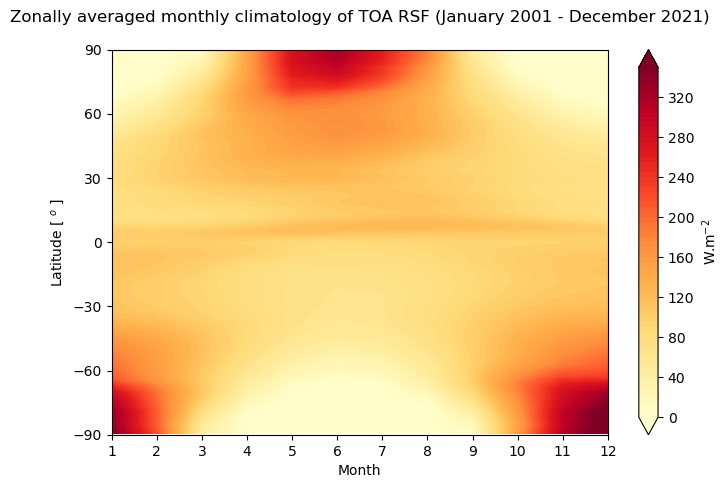

In [205]:
# Define the figure and specify size
fig7, ax7 = plt.subplots(1, 1, figsize=(8, 5))

# Configure the axes and figure title
ax7.set_xlabel('Month')
ax7.set_ylabel('Latitude [ $^o$ ]')
ax7.set_title(
    'Zonally averaged monthly climatology of TOA RSF (January 2001 - December 2021)',
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax7.set_aspect('auto')

# Plot the data as a contour plot
contour = ax7.contourf(toa_sw_zonal_clim_month.month,
                       toa_sw_zonal_clim_month.lat,
                       toa_sw_zonal_clim_month,
                       levels=clevs,
                       cmap='YlOrRd',
                       extend='both')
ax7.set_xticks(np.arange(1, 13, 1))
ax7.set_yticks(np.arange(-90, 91, 30))

# Specify the colorbar
cbar = plt.colorbar(contour)
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig7.savefig(f'{DATADIR}ceres_toa_sw_monthly_climatology.png')

**Figure 7** shows the seasonal variation of the top the atmosphere shortwave flux.

The extreme values are observed over the high latitudes. During the Arctic or Antarctic summer, the highest values of TOA reflected solar flux are observed in these regions because a lot of solar radiation is reflected by high albedo surfaces (snow or ice). During the Arctic or Antarctic winter, the lack of solar radiation induces low TOA SWF values.

###  Climatology of the top-of-atmosphere outgoing longwave radiation

In this section we will analyse the time averaged global and seasonal climatological distributions of the top of atmosphere longwave flux, also called outgoing longwave radiation (OLR).

#### Time averaged global climatological distribution of TOA OLR

To calculate the mean climatology of the TOA outgoing longwave radiation for the period January 2001 to December 2021, we select the specific time range using the Xarray method `sel()` that indexes the data and dimensions by the appropriate indexers. We then use the method `mean()` to calculate the mean along the time dimension.

In [206]:
# Select the OLR data for the whole time period
toa_lw = da_toa_lw.sel(time=slice('2001-01-01', '2021-12-31'))

# Calculate the mean along the time dimension
toa_lw_mean = toa_lw.mean(dim='time')

We now make use of a combination of the plotting libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to visualise the time averaged global climatological distribution of the TOA longwave radiation for the period January 2001 - December 2021.

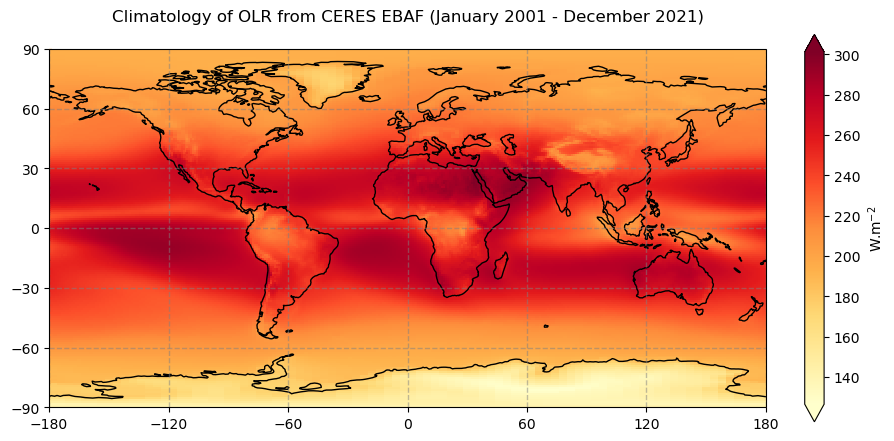

In [238]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig8, ax8 = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(toa_lw_mean.lon, toa_lw_mean.lat, toa_lw_mean, cmap='YlOrRd')

# Set the figure title, add lat/lon grid and coastlines
ax8.set_title(
    'Climatology of OLR from CERES EBAF (January 2001 - December 2021)',
    pad=20)
# Add coastlines
ax8.coastlines(color='black')
# Define gridlines and ticks
ax8.set_xticks(np.arange(-180, 181, 60))
ax8.set_yticks(np.arange(-90, 91, 30))
# Gridlines
gl = ax8.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig8.savefig(f'{DATADIR}ceres_toa_lw_climatology.png')

**Figure 8** shows the global climatology of the top of the atmosphere outgoing longwave radiation for the time period of January 2001 - December 2021.

<div style="text-align: justify"> The outgoing longwave radiation values are the highest in the tropics and decrease toward the poles. The relative minimum near the equator, in yellow colour, corresponds to the intertropical convergence zone (ITCZ) and the convection areas, where persistent and relatively high cloud cover reduces the LW radiation at the top of the atmosphere. Antarctica is cooler than the corresponding northern latitudes. </div>

#### Time averaged seasonal climatological distribution of TOA OLR

We now split the TOA outgoing longwave radiation data according to the seasons by using the `groupby()` method, with `'time.season'` as an argument; the new data are then averaged over the years.

In [208]:
# Split data array toa_lw by season
toa_lw_seasonal_climatology = toa_lw.groupby('time.season').mean('time')

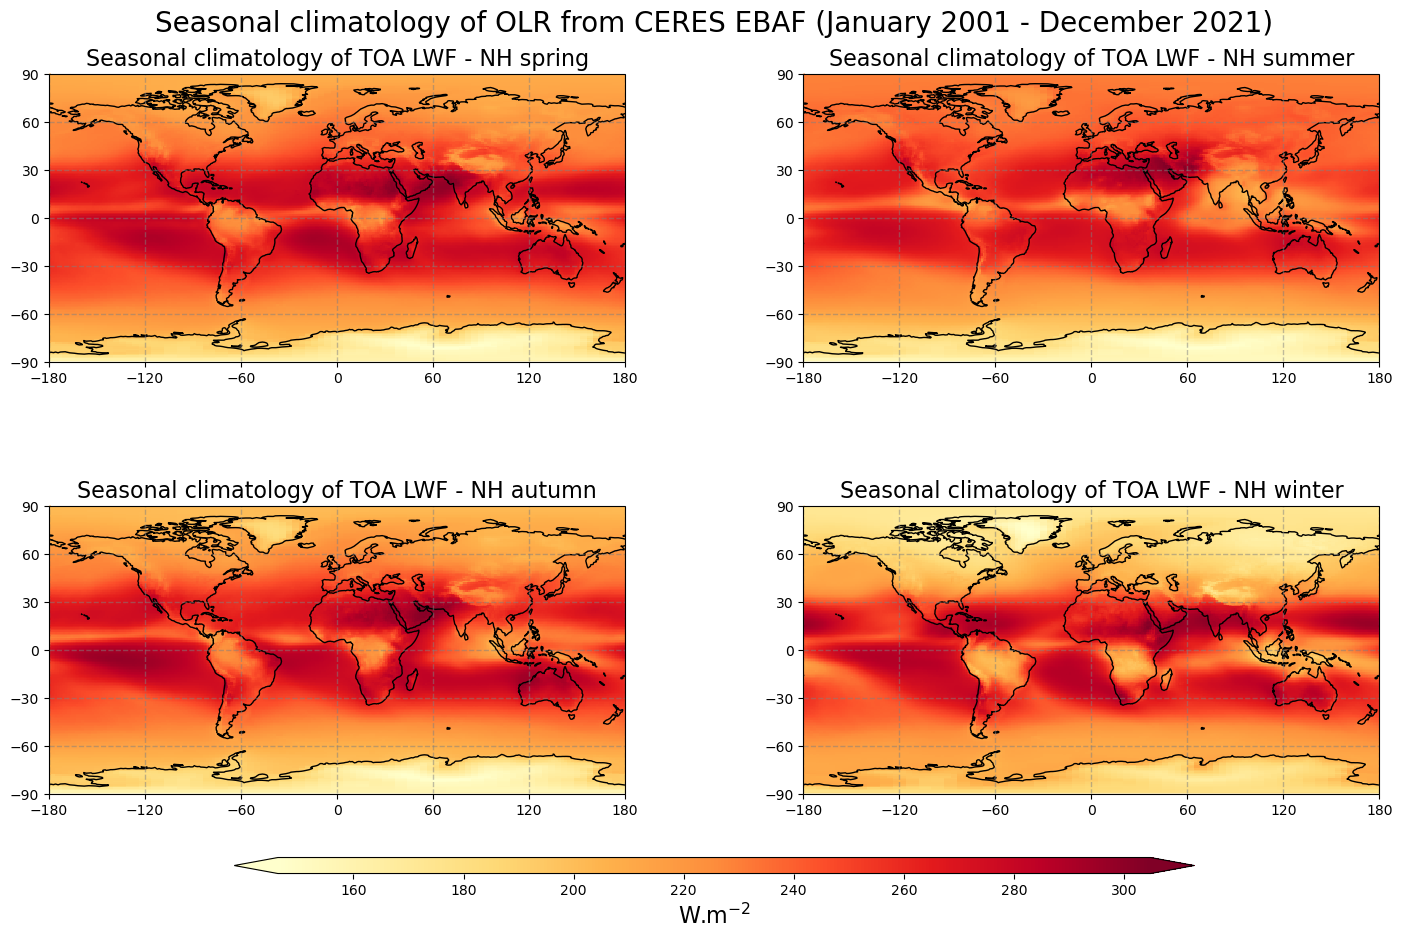

In [239]:
# Create a list of the seasons such as defined in the dataset toa_lw_seasonal_climatology:
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig9, ax9 = plt.subplots(nrows=2,
                         ncols=2,
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'MAM': 'NH spring', 'JJA': 'NH summer', 'SON': 'NH autumn', 'DJF': 'NH winter'}

# Configure the axes and subplot titles
for i_season, c_season in enumerate(seasons):
    # convert i_season index into (row, col) index
    row = i_season // 2
    col = i_season % 2
    # Plot data (coordinates and data) and define colormap
    im = ax9[row][col].pcolormesh(toa_lw_seasonal_climatology.lon,
                                  toa_lw_seasonal_climatology.lat,
                                  toa_lw_seasonal_climatology.sel(season=c_season),
                                  cmap='YlOrRd')
    # Set title and size
    ax9[row][col].set_title('Seasonal climatology of TOA LWF - ' + subtitles[c_season], fontsize=16)
    # Add coastlines
    ax9[row][col].coastlines()
    # Define grid lines and ticks (e.g. from -180 to 180 in an interval of 60)
    ax9[row][col].set_xticks(np.arange(-180, 181, 60))
    ax9[row][col].set_yticks(np.arange(-90, 91, 30))
    # Gridline
    gl = ax9[row][col].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Place the subplots
fig9.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define and place a colorbar at the bottom
cbar_ax = fig9.add_axes([0.2, -0.1, 0.6, 0.02])
cbar = fig9.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('W.m$^{-2}$', fontsize=16)

# Define an overall title
fig9.suptitle('Seasonal climatology of OLR from CERES EBAF (January 2001 - December 2021)',
              fontsize=20)

# Save the figure
fig9.savefig(f'{DATADIR}ceres_toa_lw_seasonal_climatology.png')

**Figure 9** shows the seasonal mean climatology of the outgoing longwave flux from spring to winter (top left to bottom right panels) derived from CERES EBAF.

The general pattern is overall the same as in **Figure 8** with higher values of outgoing longwave flux in the tropics and lower values in the high latitude, especially during winter. The relatively low values of OLR corresponding to high convection areas are also very well observed in the tropical summer.

#### Inter-annual variability of TOA OLR

We can now analyse the inter-annual variability of the outgoing longwave radiation at the top of the atmopshere. It is defined as the root mean square of the inter-annual anomaly in the TOA OLR.

First, we apply the `groupby()` method to group the data array by year and calculate the time-averaged TOA OLR for each year.

In [240]:
# Calculate the global time-averaged distribution of TOA OLR for each year
toa_lw_clim_year = toa_lw.groupby('time.year').mean("time")

Then, we compute the inter-annual anomaly by subtracting the global mean climatology from the the group of 21 years.

In [241]:
# Calculate the inter-annual anomaly of TOA OLR
toa_lw_anomaly = toa_lw_clim_year - toa_lw_mean

Finally, the inter-annual variability of TOA OLR is obtained by computing the standard deviation of the anomaly.

In [212]:
# Calculate the inter-annual variability of TOA OLR
toa_lw_interannual_variability = toa_lw_anomaly.std("year")

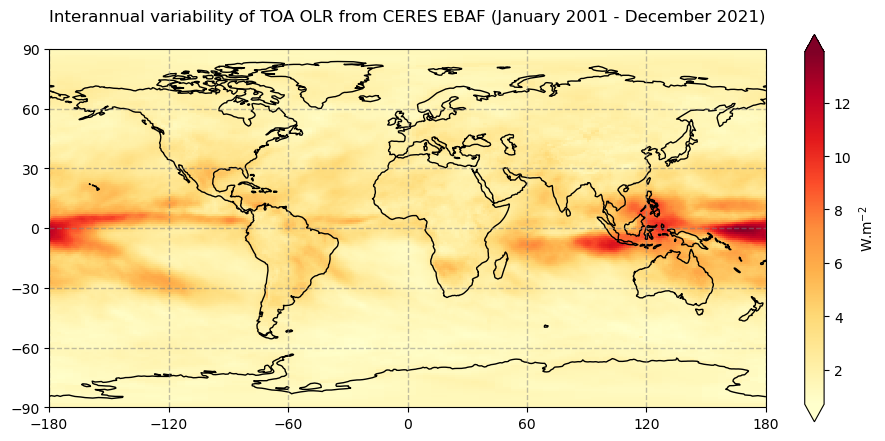

In [ ]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig10, ax10 = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(toa_lw_interannual_variability.lon,
                    toa_lw_interannual_variability.lat,
                    toa_lw_interannual_variability,
                    cmap='YlOrRd')

# Set the figure title, add lat/lon grid and coastlines
ax10.set_title(
    'Interannual variability of TOA OLR from CERES EBAF (January 2001 - December 2021)',
    pad=20)
# Add coastlines
ax10.coastlines(color='black')
# Define gridlines and ticks
ax10.set_xticks(np.arange(-180, 181, 60))
ax10.set_yticks(np.arange(-90, 91, 30))
# Gridlines
gl = ax10.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig10.savefig(f'{DATADIR}ceres_toa_lw_interannual_variability.png')

**Figure 10** shows that the main variability occurs in the convective regions, in particular, in the Monsoon regions and along the Pacific Basin, following “El Niño” and “La Niña” oscillations. 

#### Zonally averaged montly mean climatology of TOA OLR

We will now calculate the monthly mean climatology of the outgoing longwave radiation over the time period January 2001 - December 2021 by first applying the `groupby()` method to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for the total column water vapour based on reference January 2001 - December 2021. 

In [214]:
toa_lw_clim_month = toa_lw.groupby('time.month').mean("time")

Before viewing the zonal monthly climatology of the OLR, let us average across the longitude bands with the `mean()` method, align the **time** dimension coordinate with the x axis and the **lat** dimension coordinate along the y axis by using the method `transpose()`...

In [215]:
toa_lw_zonal_clim_month = toa_lw_clim_month.mean(dim="lon").transpose()

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [216]:
# Define contour parameters (min, max and step)
vdiv = 1
vmin = 100
vmax = 300
clevs = np.arange(vmin, vmax, vdiv)

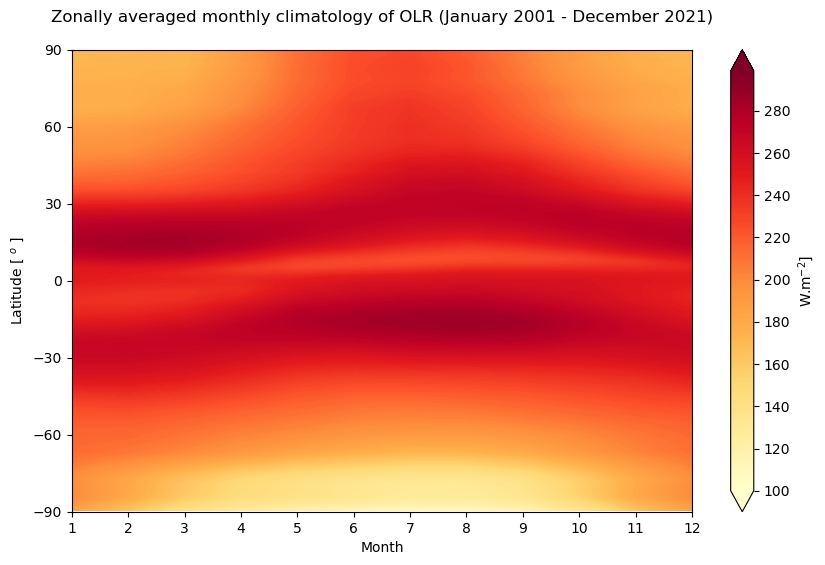

In [217]:
# Define the figure and specify size
fig11, ax11 = plt.subplots(1, 1, figsize=(10, 6))

# Configure the axes and figure title
ax11.set_xlabel('Month')
ax11.set_ylabel('Latitude [ $^o$ ]')
ax11.set_title(
    'Zonally averaged monthly climatology of OLR (January 2001 - December 2021)',
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax11.set_aspect('auto')

# Plot the data as a contour plot
contour = ax11.contourf(toa_lw_zonal_clim_month.month,
                        toa_lw_zonal_clim_month.lat,
                        toa_lw_zonal_clim_month,
                        levels=clevs,
                        cmap='YlOrRd',
                        extend='both')
ax11.set_xticks(np.arange(1, 13, 1))
ax11.set_yticks(np.arange(-90, 91, 30))

# Specify the colorbar
cbar = plt.colorbar(contour)
cbar.set_label('W.m$^{-2}$]')

# Save the figure
fig11.savefig(f'{DATADIR}ceres_toa_lw_monthly_climatology.png')

**Figure 11** shows the seasonal variation of the top of the atmosphere longwave flux.

The lowest values of the outgoing longwave flux are observed over the coldest surfaces corresponding to the high latitude winter. Two bands of high values over the tropics separated by relatively low values near the equator (corresponding to the ITCZ) oscillate and reach a maximum near the equator in the winter hemisphere, confirming the influence of (relatively) low convection and incoming solar radiation (high surface temperatures) on the OLF.

###  Climatology of the top-of-atmosphere net Earth's radiation budget

In this section we will analyse the time averaged global and seasonal climatological distributions of the net Earth's radiative budget (or net radiative flux). It is defined as the balance between the incoming (solar) and outgoing (solar reflelcted and Earth emitted) energy at the top of the atmospohere.

#### Time averaged global climatological distribution of TOA net ERB

To calculate the mean climatology of the net radiative flux at the the top of the atmosphere, we just have to compute the difference between the time averaged incoming solar flux and the sum of shortwave (solar reflected) and longwave (Earth emitted) fluxes at the top of the atmposphere for the period January 2001 to December 2021. All the variables have been computed in the previous sections.

In [218]:
# Calculate the mean climatology of the net radiation at the top of the atmosphere
toa_erb_mean = solar_mean - toa_sw_mean - toa_lw_mean

We now make use of a combination of the plotting libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to visualize the time averaged global climatological distribution of the TOA net radiative flux for the period January 2001 - December 2021.

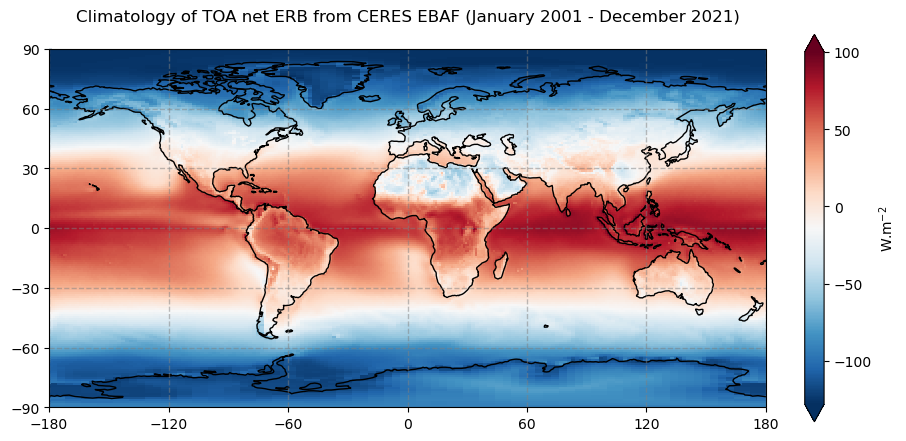

In [ ]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig12, ax12 = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(toa_erb_mean.lon, toa_erb_mean.lat, toa_erb_mean, cmap='RdBu_r')

# Set the figure title, add lat/lon grid and coastlines
ax12.set_title(
    'Climatology of TOA net ERB from CERES EBAF (January 2001 - December 2021)',
    pad=20)
# Add coastlines
ax12.coastlines(color='black')
# Define gridlines and ticks
ax12.set_xticks(np.arange(-180, 181, 60))
ax12.set_yticks(np.arange(-90, 91, 30))
# Gridlines
gl = ax12.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig12.savefig(f'{DATADIR}ceres_toa_erb_climatology.png')

**Figure 12** shows the global climatology of the (net) Earth's radiation budget at the top of the atmosphere for the time period of January 2001 - December 2021.

In general, the net radiation is positive (energy surplus) in the tropical areas (shown in red) and negative (energy deficit) in high latitudes (in blue). However, in some of the desert regions the TOA net ERB becomes negative due to the combined high values of albedo and OLR (Sahara desert or Arabic peninsula for instance). Areas in which incoming radiation balances the outgoing are in white.

#### Time averaged seasonal climatological distribution of TOA ERB

To compute the time averaged seasonal climatological distribution of TOA net ERB, the data are splitted according to the seasons by using the `groupby()` method, with `'time.season'` as an argument, and then averaged over the years.

In [220]:
# Select the TOA ERB data for the whole time period
toa_erb = da_toa_erb.sel(time=slice('2001-01-01', '2021-12-31'))

# Split data array TOA ERB by season
toa_erb_seasonal_climatology = toa_erb.groupby('time.season').mean('time')

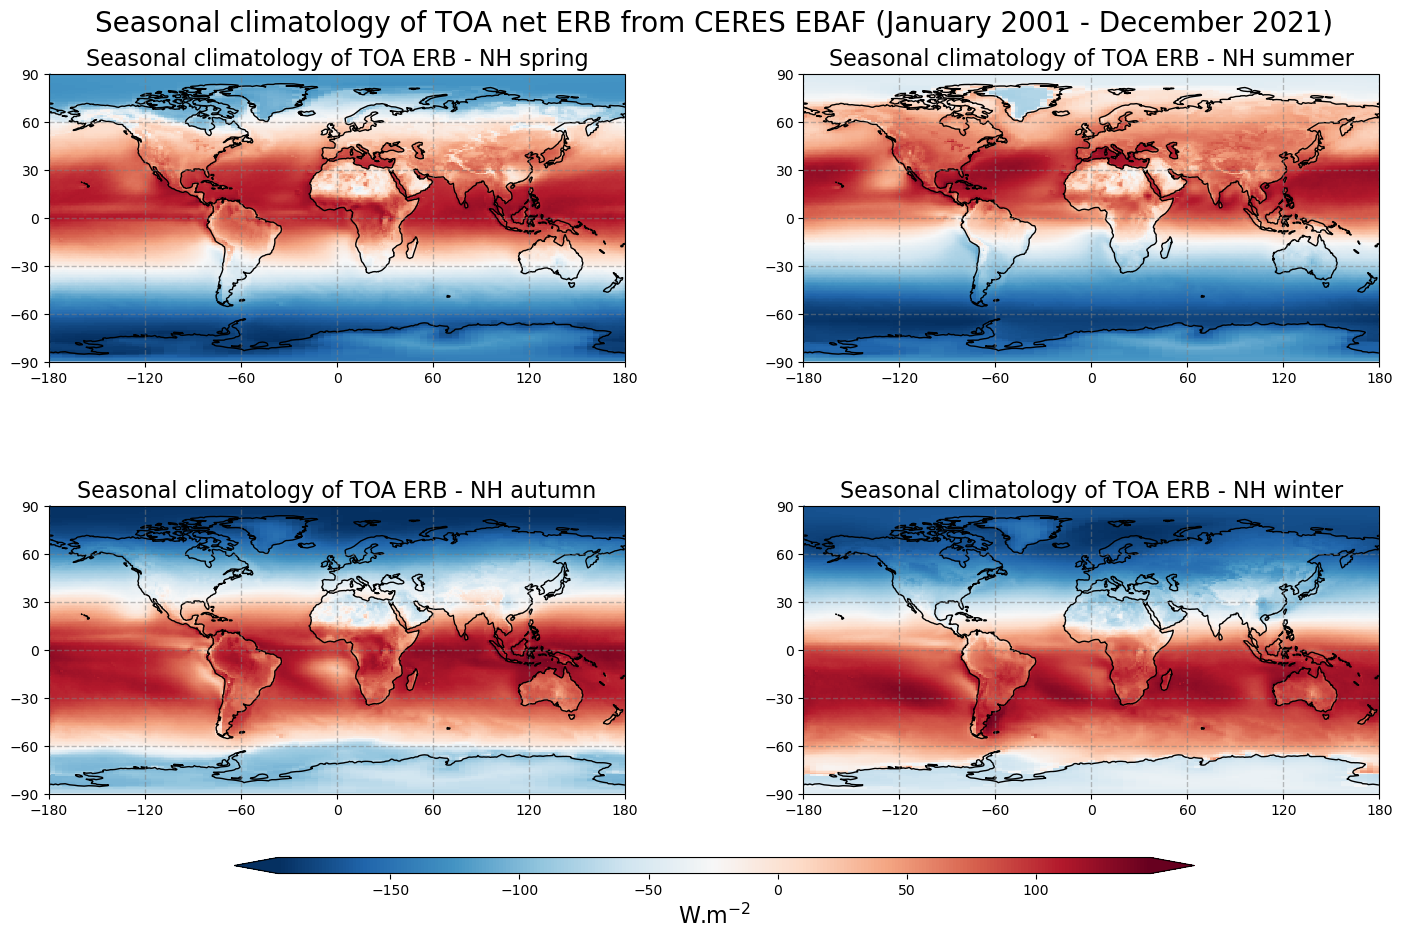

In [242]:
# Create a list of the seasons such as defined in the dataset toa_erb_seasonal_climatology:
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig13, ax13 = plt.subplots(nrows=2,
                           ncols=2,
                           subplot_kw={'projection': ccrs.PlateCarree()},
                           figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'MAM': 'NH spring', 'JJA': 'NH summer', 'SON': 'NH autumn', 'DJF': 'NH winter'}

# Configure the axes and subplot titles
for i_season, c_season in enumerate(seasons):
    # convert i_season index into (row, col) index
    row = i_season // 2
    col = i_season % 2
    # Plot data (coordinates and data) and define colormap
    im = ax13[row][col].pcolormesh(toa_erb_seasonal_climatology.lon,
                                   toa_erb_seasonal_climatology.lat,
                                   toa_erb_seasonal_climatology.sel(season=c_season),
                                   cmap='RdBu_r')
    # Set title and size
    ax13[row][col].set_title('Seasonal climatology of TOA ERB - ' + subtitles[c_season], fontsize=16)
    # Add coastlines
    ax13[row][col].coastlines()
    # Define grid lines and ticks (e.g. from -180 to 180 in an interval of 60)
    ax13[row][col].set_xticks(np.arange(-180, 181, 60))
    ax13[row][col].set_yticks(np.arange(-90, 91, 30))
    # Gridline
    gl = ax13[row][col].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Place the subplots
fig13.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define and place a colorbar at the bottom
cbar_ax = fig13.add_axes([0.2, -0.1, 0.6, 0.02])
cbar = fig13.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('W.m$^{-2}$', fontsize=16)

# Define an overall title
fig13.suptitle('Seasonal climatology of TOA net ERB from CERES EBAF (January 2001 - December 2021)',
               fontsize=20)

# Save the figure
fig13.savefig(f'{DATADIR}ceres_toa_erb_seasonal_climatology.png')

**Figure 13** shows the seasonal mean climatology of the TOA net radiation from spring to winter (top left to bottom right panels) derived from CERES EBAF.

The general pattern exhibits negative values of TOA net ERB in the high latitudes and a band of positive values that oscillates (between 60° N/S) around the equator, reaching a maximum in the summer hemisphere (except for high albedo regions such as Sahara desert and the Arabic Peninsula). It confirms the dominant effect of solar radiation on the net Earth's radiation budget. In the high latitudes of the summer hemisphere, because of the high surface (snow, ice) albedo, the reflected solar radiation compensates the incident solar radiation.

#### Zonally averaged montly mean climatology of TOA net ERB

We will now calculate the monthly mean climatology of TOA net radiative flux over the period January 2001 - December 2021 by first applying the `groupby()` method to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for the TOA ERB based on reference January 2001 - December 2021.

In [222]:
toa_erb_clim_month = toa_erb.groupby('time.month').mean("time")

Before viewing the zonal monthly climatology of the TOA ERB, we average across the longitude bands with the `mean()` method and align the **time** dimension coordinate with the x axis and the **lat** dimension coordinate along the y axis using the method `transpose()`...

In [223]:
toa_erb_zonal_clim_month = toa_erb_clim_month.mean(dim="lon").transpose()

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [224]:
# Define contour parameters (min, max and step)
vdiv = 1
vmin = -200
vmax = 200
clevs = np.arange(vmin, vmax, vdiv)

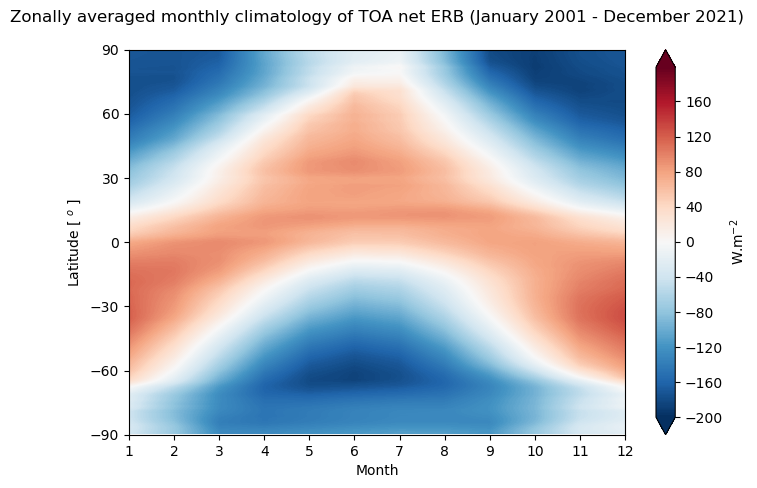

In [225]:
# Define the figure and specify size
fig14, ax14 = plt.subplots(1, 1, figsize=(8, 5))

# Configure the axes and figure title
ax14.set_xlabel('Month')
ax14.set_ylabel('Latitude [ $^o$ ]')
ax14.set_title(
    'Zonally averaged monthly climatology of TOA net ERB (January 2001 - December 2021)',
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax14.set_aspect('auto')

# Plot the data as a contour plot
contour = ax14.contourf(toa_erb_zonal_clim_month.month,
                        toa_erb_zonal_clim_month.lat,
                        toa_erb_zonal_clim_month,
                        levels=clevs,
                        cmap='RdBu_r',
                        extend='both')
ax14.set_xticks(np.arange(1, 13, 1))
ax14.set_yticks(np.arange(-90, 91, 30))

# Specify the colorbar
cbar = plt.colorbar(contour)
cbar.set_label('W.m$^{-2}$')

# Save the figure
fig14.savefig(f'{DATADIR}ceres_toa_erb_monthly_climatology.png')

**Figure 14** shows the seasonal variation of the top of atmosphere net Earth's radiation budget.

The general pattern of the Hovmöller diagram is overall the same as the seasonal climatological distribution (**Figure 13**), exhibiting the oscillation of the band of positive values of TOA net ERB around the equator that reaches a maximum in the summer tropics. This confirms the dominant effect of the solar radiation and the equator-versus-pole energy imbalance which is the main driver of atmospheric and oceanic circulations.

Modifications in the globally averaged net radiation flux are a good indicator of climate change since if this average is not close to zero it will imply an increase or decrease of the average temperature of the globe. In the next use case, we will therefore analyse the temporal evolution of the Earth's radiation budget and its annual seasonal variation.

##  Time series and trend analysis of the Earth's Radiation Budget

After looking at the time averaged global distribution of the Earth's radiation budget, we further investigate the dataset. The CERES-EBAF product spans over 20 years of satellite observations, and another useful way of analysing and visualizing the temporal evolution of total column water vapour is using the time series. We will calculate global time series, plot it, and discuss most important features.

We first create a temporal subset for the time period January 2001 to December 2021.

In [226]:
# Select time period for the incoming shortwave radiation data array
ceres_solar = da_solar.sel(time=slice('2001-01-01', '2021-12-31'))

# Select time period for the outgoing shortwave radiation data array
ceres_toa_sw = da_toa_sw.sel(time=slice('2001-01-01', '2021-12-31'))

# Select time period for the outgoing longwave radiation data array
ceres_toa_lw = da_toa_lw.sel(time=slice('2001-01-01', '2021-12-31'))

# Compute the net radiative flux for the selected time period
ceres_toa_erb = ceres_solar - ceres_toa_sw - ceres_toa_lw

### Spatial aggregation

We would like to visualise these data, not in maps but as one dimensional time series of global average values. To do this, we will first need to aggregate the data spatially to create a single global average at each time step. In order to aggregate over the latitudinal dimension, we need to take into account the variation in area as a function of latitude. We will do this by using the cosine of the latitude as a proxy:

In [227]:
# Define weights as the cosine of latitudes
weights = np.cos(np.deg2rad(ceres_solar.lat))
weights.name = "weights"

# Spatial aggregation of CERES-EBAF incident solar flux
ceres_solar_weighted = ceres_solar.weighted(weights)

# Spatial aggregation of CERES-EBAF reflected solar flux
ceres_toa_sw_weighted = ceres_toa_sw.weighted(weights)

# Spatial aggregation of CERES-EBAF Earth emitted longwave flux
ceres_toa_lw_weighted = ceres_toa_lw.weighted(weights)

# Spatial agregation of CERES-EBAF net radiative flux
ceres_toa_erb_weighted = ceres_toa_erb.weighted(weights)

The next step is to compute the mean across the latitude and longitude dimensions of the weighted data array with the `mean()` method.

In [228]:
# Weighted mean of CERES-EBAF incident solar flux
ceres_solar_wmean = ceres_solar_weighted.mean(dim=("lat", "lon"))

# Weighted mean of CERES-EBAF reflected solar flux
ceres_toa_sw_wmean = ceres_toa_sw_weighted.mean(dim=("lat", "lon"))

# Weighted mean of CERES-EBAF Earth emitted longwave flux
ceres_toa_lw_wmean = ceres_toa_lw_weighted.mean(dim=("lat", "lon"))

# Weighted mean of CERES net radiative flux
ceres_toa_erb_wmean = ceres_toa_erb_weighted.mean(dim=("lat", "lon"))

### Time series and trend analysis of the top-of-atmosphere incoming solar radiation

#### Global time series of TIS

Now we can plot the time series of globally averaged TIS data over time using the `plot()` method.

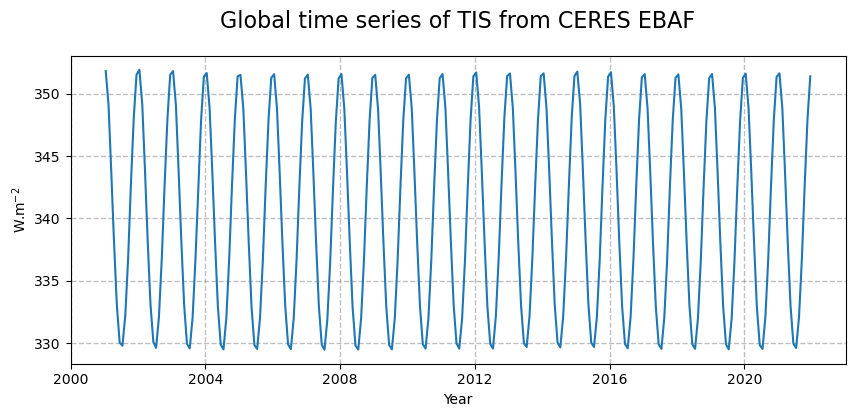

In [229]:
# Define the figure and specify size
fig15, ax15 = plt.subplots(1, 1, figsize=(10, 4))

# Configure the axes and figure title
ax15.set_xlabel('Year')
ax15.set_ylabel('W.m$^{-2}$')
ax15.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax15.set_title('Global time series of TIS from CERES EBAF', fontsize=16, pad=20)

# Plot the data
ax15.plot(ceres_solar_wmean.time, ceres_solar_wmean)

# Save the figure
fig15.savefig(f'{DATADIR}ceres_isf_global_timeseries.png')

**Figure 15** shows the time series of the incoming solar flux at the top of the atmosphere.

From the time series, we can infer a clear seasonal cycle with an amplitude of over 20 W/m$^{2}$ in the global space and time averaged TSI, associated to the Earth's orbit around the sun. Another very slight long-term seasonal trend is also noticeable, that corresponds to the sunspot cycle. The Earth and solar seasonal cycles will now be studied in more details by the seasonal decomposition of the incoming solar flux.

#### Trend analysis and seasonal cycle of TIS

The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

To this end, we will convert the Xarray Data Array into a time series with the [pandas](https://pandas.pydata.org/) library before decomposing it into the trend, the seasonal cycle and the residuals by using the `seasonal_decompose()` method and visualizing the results.

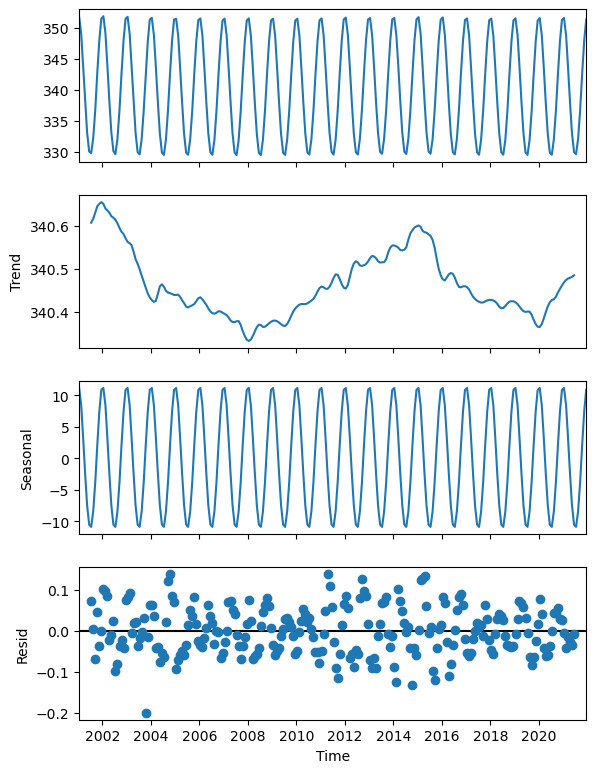

In [230]:
# Convert the Xarray data array ceres_solar_wmean into a time series
ceres_solar_wmean_series = pd.Series(ceres_solar_wmean)
# Define the time dimension of ceres_solar_weighted_mean as the index of the time series
ceres_solar_wmean_series.index = ceres_solar_wmean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
ceres_solar_seasonal_decomposition = seasonal_decompose(ceres_solar_wmean_series,
                                                        model='additive',
                                                        period=12)

# Plot the resulting seasonal decomposition
fig16 = ceres_solar_seasonal_decomposition.plot()
fig16.set_size_inches(6, 8)
fig16.axes[-1].set_xlabel('Time')
plt.savefig(f'{DATADIR}ceres_solar_timeseries_climatology.png')

**Figure 16** shows the decomposition of the TIS time series into the trend corresponding to the sunspot cycle (2nd panel), and the seasonal cycle with the confirmed amplitude of 20 W.m⁻² (3rd panel), from which are derived the anomalies or de-trended and de-seasonalised time series that have the characteristics of an uncorrelated noise pattern (4th panel).

###  Time series and trend analysis of the top-of-atmosphere reflected solar flux

#### Global time series of TOA RSF

We will now plot the time series of globally averaged TOA RSF data over time using the `plot()` method.

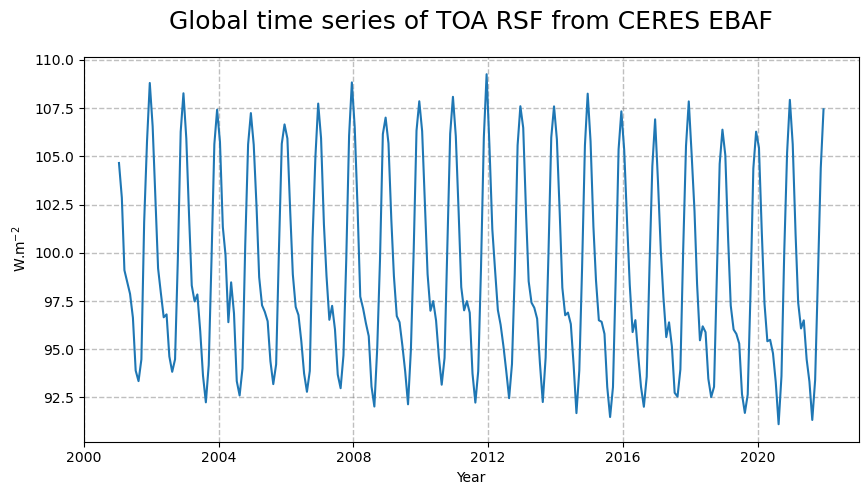

In [231]:
# Define the figure and specify size
fig17, ax17 = plt.subplots(1, 1, figsize=(10, 5))

# Configure the axes and figure title
ax17.set_xlabel('Year')
ax17.set_ylabel('W.m$^{-2}$')
ax17.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax17.set_title('Global time series of TOA RSF from CERES EBAF', fontsize=18, pad=20)

# Plot the data
ax17.plot(ceres_toa_sw_wmean.time, ceres_toa_sw_wmean)

# Save the figure
fig17.savefig(f'{DATADIR}ceres_toa_sw_global_timeseries.png')

**Figure 17** shows the time series of the reflected solar flux at the top of the atmosphere.

From the time series of the global space and time averaged RSF, we can infer a clear seasonal cycle associated to the Earth's orbit around the sun and a long-term seasonal cycle corresponding to the sunspot cycle together with a negative trend. They will now be further examined through the seasonal decomposition of the incoming solar flux.

#### Trend analysis and seasonal cycle of TOA RSF

The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

To this end, we will convert the Xarray Data Array into a time series with the [pandas](https://pandas.pydata.org/) library before decomposing it into the trend, the seasonal cycle and the residuals by using the `seasonal_decompose()` method and visualizing the results.

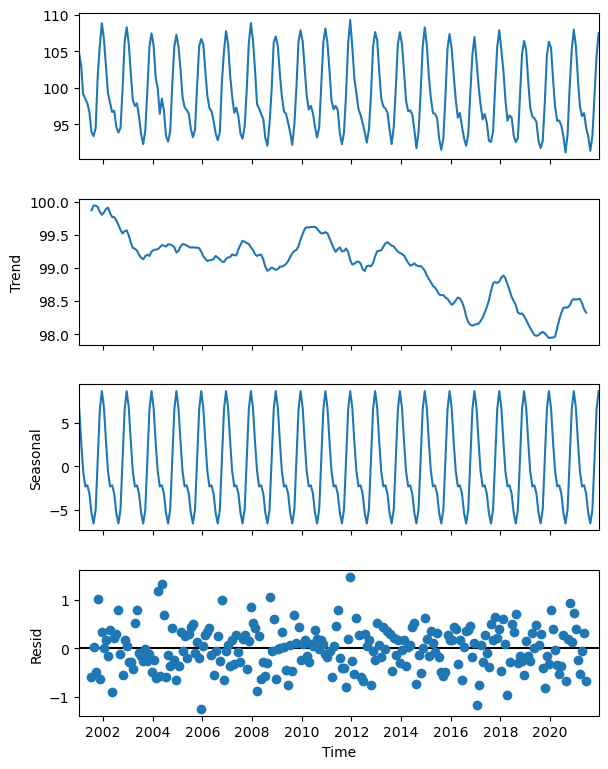

In [232]:
# Convert the Xarray data array ceres_toa_sw_wmean into a time series
ceres_toa_sw_wmean_series = pd.Series(ceres_toa_sw_wmean)
# Define the time dimension of ceres_toa_sw_wmean as the index of the time series
ceres_toa_sw_wmean_series.index = ceres_toa_sw_wmean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
ceres_toa_sw_seasonal_decomposition = seasonal_decompose(ceres_toa_sw_wmean_series,
                                                         model='additive',
                                                         period=12)

# Plot the resulting seasonal decomposition
fig18 = ceres_toa_sw_seasonal_decomposition.plot()
fig18.set_size_inches(6, 8)
fig18.axes[-1].set_xlabel('Time')
plt.savefig(f'{DATADIR}ceres_toa_sw_timeseries_climatology.png')

**Figure 18** shows the decomposition of the TOA RSF time series into a negative trend of ~-0.1 W.m⁻².year⁻¹ (2nd panel) and a seasonal cycle with an amplitude of ~15 W.m⁻² (3rd panel), from which are derived the anomalies that have the characteristics of an uncorrelated noise pattern (4th panel).

As explained earlier (see the climatologcal distribution of the TOA RSF), the minimum values of the reflected solar flux are found over cloud free ocean areas and the maximum values over high albedo surfaces, such as snow or deserts. The negative trend can thus be due to a loss of snow and ice, especially in the Arctic and Antarctic regions.

###  Time series and trend analysis of the top-of-atmosphere outgoing longwave radiation

#### Global time series of TOA OLR

We will now plot the time series of globally averaged outgoing longwave radiation data over time using the `plot()` method.

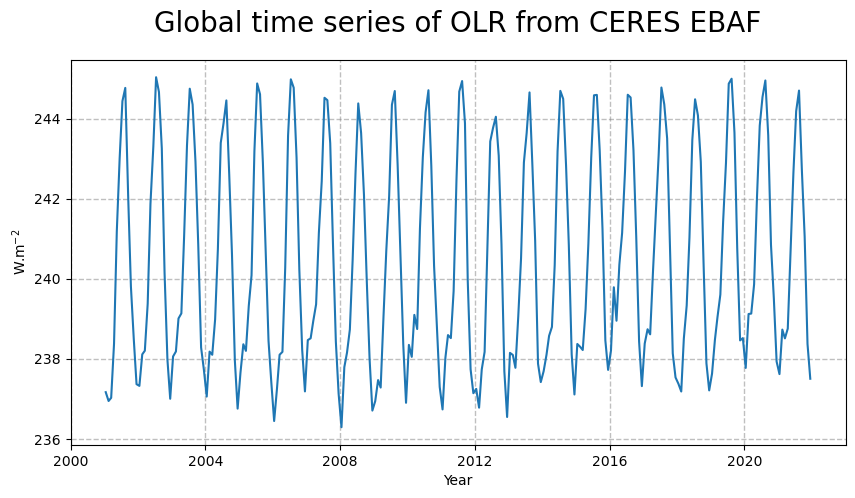

In [233]:
# Define the figure and specify size
fig19, ax19 = plt.subplots(1, 1, figsize=(10, 5))

# Configure the axes and figure title
ax19.set_xlabel('Year')
ax19.set_ylabel('W.m$^{-2}$')
ax19.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax19.set_title('Global time series of OLR from CERES EBAF', fontsize=20, pad=20)

# Plot the data
ax19.plot(ceres_toa_lw_wmean.time, ceres_toa_lw_wmean)

# Save the figure
fig19.savefig(f'{DATADIR}ceres_toa_lw_global_timeseries.png')

**Figure 19** shows the time series of the outgoing longwave radiation at the top of the atmosphere. From the time series, we can infer a seasonal pattern along with a trend in the global space and time averaged TOA OLR.

We will now procede to the seasonal decomposition of the Earth-emitted longwave radiation at the top of the atmosphere and analyse more specifically the trend and seasonal cycle of CERES-EBAF OLR.

#### Trend analysis and seasonal cycle of TOA OLR

The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

To this end, we will convert the Xarray Data Array into a time series with the [pandas](https://pandas.pydata.org/) library before decomposing it into the trend, the seasonal cycle and the residuals by using the `seasonal_decompose()` method and visualizing the results.

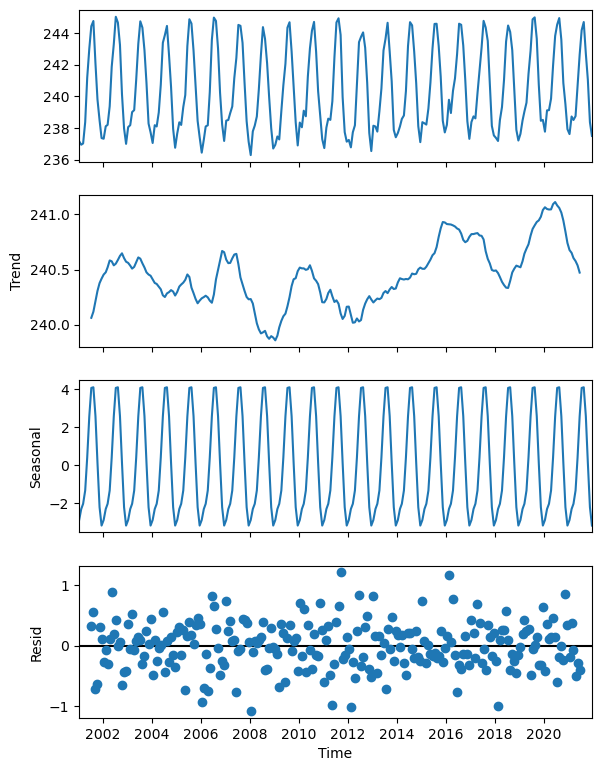

In [234]:
# Convert the Xarray data array ceres_toa_lw_wmean into a time series
ceres_toa_lw_wmean_series = pd.Series(ceres_toa_lw_wmean)
# Define the time dimension of ceres_toa_lw_wmean as the index of the time series
ceres_toa_lw_wmean_series.index = ceres_toa_lw_wmean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
ceres_toa_lw_seasonal_decomposition = seasonal_decompose(ceres_toa_lw_wmean_series,
                                                         model='additive',
                                                         period=12)

# Plot the resulting seasonal decomposition
fig20 = ceres_toa_lw_seasonal_decomposition.plot()
fig20.set_size_inches(6, 8)
fig20.axes[-1].set_xlabel('Time')
plt.savefig(f'{DATADIR}ceres_toa_lw_timeseries_climatology.png')

**Figure 20** shows the decomposition of the outgoing lonwave radiation time series into a positive trend of ~0.05 W.m⁻².year⁻¹(2nd panel), and a seasonal cycle with an amplitude of ~8 W.m⁻² (3rd panel), from which are derived the anomalies that have the characteristics of uncorrelated noise pattern (4th panel).

The observed inter-annual variations in the 2nd panel of **Figure 20** suggest an influence of the “El Niño” or “La Niña” Southern Oscillation on the TOA OLR. The increase in this Earth-emitted longwave radiation is clearly related to the increase of surface temperatures.

###  Time series and trend analysis of the top-of-atmosphere net Earth's radiation budget

#### Global time series of TOA net ERB

We will now plot the time series of the globally averaged TOA net Earth's radiative flux over time using the `plot()` method.

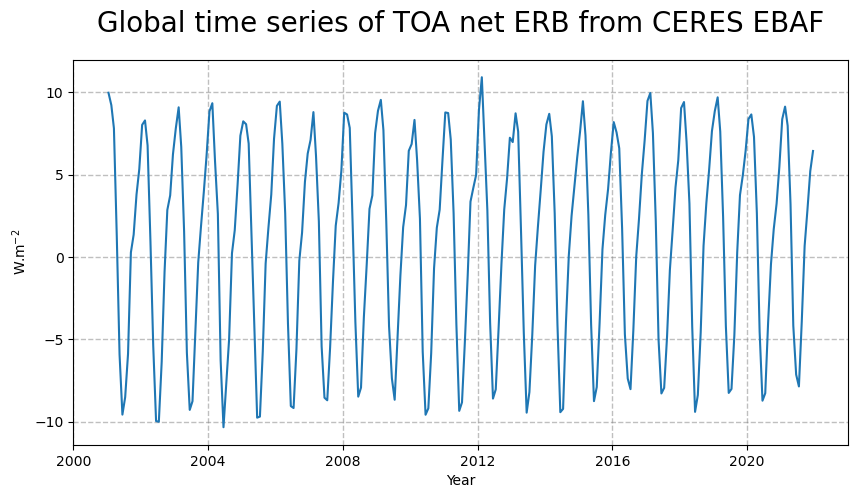

In [235]:
# Define the figure and specify size
fig21, ax21 = plt.subplots(1, 1, figsize=(10, 5))

# Configure the axes and figure title
ax21.set_xlabel('Year')
ax21.set_ylabel('W.m$^{-2}$')
ax21.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax21.set_title('Global time series of TOA net ERB from CERES EBAF', fontsize=20, pad=20)

# Plot the data
ax21.plot(ceres_toa_erb_wmean.time, ceres_toa_erb_wmean)

# Save the figure
fig21.savefig(f'{DATADIR}ceres_toa_erb_global_timeseries.png')

**Figure 21** shows the time series of the net Earth's radiation budget at the top of the atmosphere. From the time series, we can infer a seasonal pattern together with a slightly increasing trend in the global space and time averaged TOA net ERB.

<div style="text-align: justify"> Since CERES EBAF is a stable and robust product which has been validated with other data, this trend can be assumed to be a real climatological variability in the net Earth's radiation flux at the top of the atmosphere. </div>

<div style="text-align: justify"> We will now procede to the seasonal decomposition of the net Earth's radiation budget and analyse more specifically the trend and seasonal cycle of the TOA net ERB. </div>

#### Trend analysis and seasonal cycle of TOA net ERB

<br>
The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

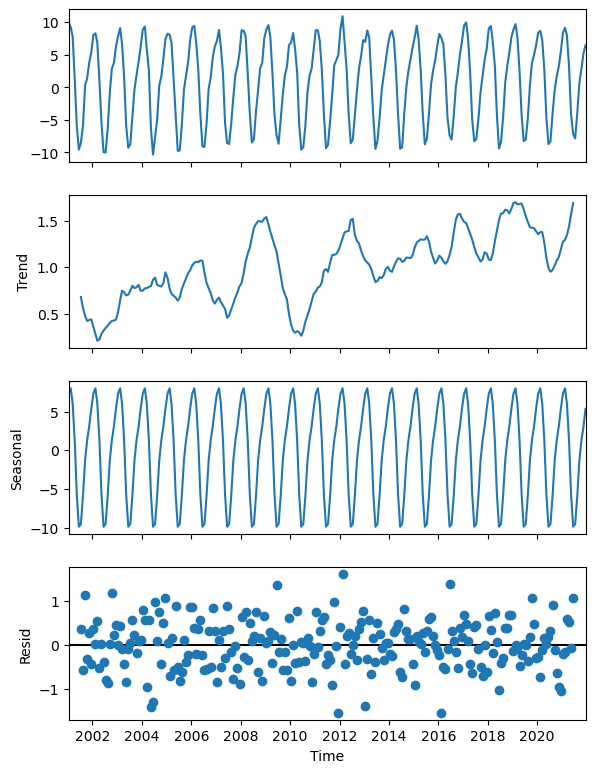

In [236]:
# Convert the Xarray data array ceres_toa_erb_wmean into a time series
ceres_toa_erb_wmean_series = pd.Series(ceres_toa_erb_wmean)
# Define the time dimension of ceres_toa_sw_wmean as the index of the time series
ceres_toa_erb_wmean_series.index = ceres_toa_erb_wmean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
ceres_toa_erb_seasonal_decomposition = seasonal_decompose(ceres_toa_erb_wmean_series,
                                                          model='additive',
                                                          period=12)

# Plot the resulting seasonal decomposition
fig22 = ceres_toa_erb_seasonal_decomposition.plot()
fig22.set_size_inches(6, 8)
fig22.axes[-1].set_xlabel('Time')
plt.savefig(f'{DATADIR}ceres_toa_erb_timeseries_climatology.png')

**Figure 22** shows the decomposition of the CERES-EBAF TOA net ERB time series into a positive trend of ~0.05 W.m⁻².year⁻¹ (2nd panel), and a seasonal cycle with an amplitude of ~20 W.m⁻² (3rd panel), from which are derived the anomalies that have the characteristics of uncorrelated noise pattern (4th panel).

The trend analysis presents an oscilation around the year 2010 that can be related to a moderate “El Niño” event in this time period. The positive trend of the net Earth's radiative flux confirms global warming.

##  Conclusion

In this notebook we have provided use cases, based on the Cloud and Earth’s Radiant Energy System (CERES) Energy Balanced And Filled (EBAF) Earth's radiation budget (ERB) data record, to illustrate the way this dataset can be used to study, analyse and visualise this essential climate variable. The current dataset indicates a clear increase of the net Earth's radiative flux between January 2001 and December 2021. Comparisons with other independent datasets can be made to further investigate the trends that can be attributed to global warming, El-Niño events and external solar cycle forcing.

## Appendix

Clean up your directory of the netCDF files you unzipped.

You can set the `save_merged_netcdf` flag to `True` (and choose a filename)
if you want to merge the data into a single netcdf before closing

In [237]:
# Flag to save the merged netCDF file
save_merged_netcdf = False
# Filename for the netCDF file which contains the merged contents of the monthly files.
merged_netcdf_file = os.path.join(DATADIR, 'ceres-erb-monthly.nc')

if save_merged_netcdf:
    ds_ceres.to_netcdf(merged_netcdf_file)

# Recursively delete unpacked data
for f in filelist:
    os.remove(f)
